# Image Scaling

One imporatant image operation is *scaling*, that is, change the number of pixels along each direction of the image. First consider the so-called *downsampling* of an image by a factor of 2. While we could simply extract every second pixel in each row and each column, a slightly better option is to average the values in each 2-by-2 block:

In [1]:
# Code from previous section
using PyPlot
using Statistics
A = imread("sample_photo.png")
B = mean(A, dims=3)[:,:,1]
function imshow_scale(A)
    # Like imshow(A) but scales the values to [0,1] and supports grayscale
    
    A .-= minimum(A)            # Scale and shift to [0,1]
    A ./= maximum(A)
    if ndims(A) < 3
        A = reshape(A, size(A,1), size(A,2), 1)
    end
    if size(A,3) == 1
        A = repeat(A, 1, 1, 3)  # Set R=G=B for grayscale
    end
    imshow(A)
    end;

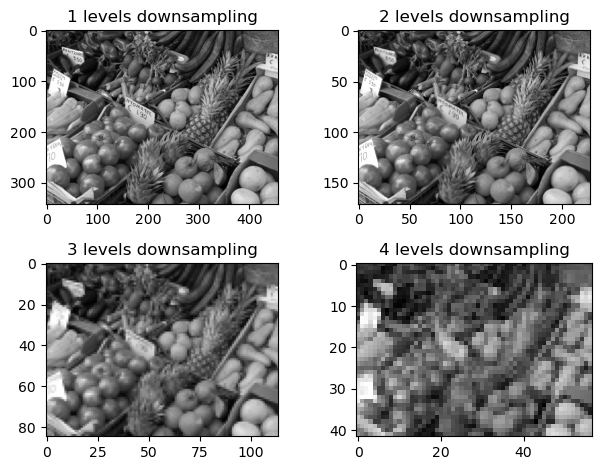

In [2]:
function image_downsample(A)
    # For simplicity, ignore last row/column if size is odd
    sz = size(A)
    sz2 = sz .÷ 2
    B = (A[1:2:2sz2[1], 1:2:2sz2[2], :] .+
         A[2:2:2sz2[1], 1:2:2sz2[2], :] .+
         A[1:2:2sz2[1], 2:2:2sz2[2], :] .+
         A[2:2:2sz2[1], 2:2:2sz2[2], :]) ./ 4
end

C = copy(B);
for i = 1:4
    C = image_downsample(C);
    subplot(2,2,i), imshow_scale(C)
    title("$(i) levels downsampling")
end
tight_layout()

*Upscaling* an image, that is, increasing its size, is a more difficult operation. Is is obviously impossible to know the intensity of the added pixels, but assuming the variations are small one can for example interpolate between the given values. One simple interpolation is *bilinear*, which for a factor of 2 simply becomes averaging between neighboring pixel values:

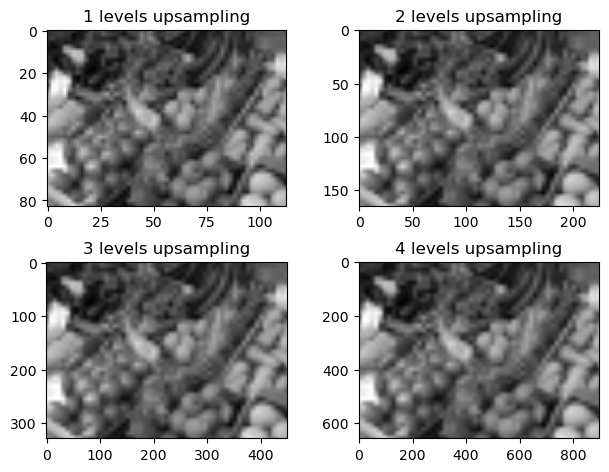

In [3]:
function image_upsample(A)
    sz = size(A)
    B = zeros(Float32, 2sz[1]-1, 2sz[2]-1, sz[3])
    B[1:2:end, 1:2:end, :] .= A
    B[2:2:end-1, 1:2:end, :] .= (A[1:end-1,:,:] .+ A[2:end,:,:]) ./ 2
    B[1:2:end, 2:2:end-1, :] .= (A[:,1:end-1,:] .+ A[:,2:end,:]) ./ 2
    B[2:2:end-1, 2:2:end-1, :] .= (A[1:end-1,1:end-1,:] .+ A[1:end-1,2:end,:]
                               .+  A[2:end,1:end-1,:] .+ A[2:end,2:end,:]) ./ 4
    return B
end

D = copy(C);
for i = 1:4
    D = image_upsample(D);
    subplot(2,2,i), imshow_scale(D)
    title("$(i) levels upsampling")
end
tight_layout()

The resulting image is of course much less detailed that the original, but that was expected since we reduced its size by a factor of $2^4=16$ in each direction:

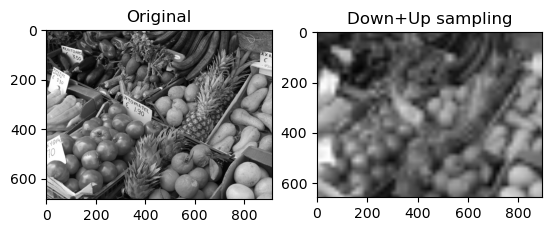

In [4]:
subplot(1,2,1); imshow_scale(B); title("Original");
subplot(1,2,2); imshow_scale(D); title("Down+Up sampling");